## Environment Setup


### Pip Installations & Imports

In [2]:
# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing/Outputting
import random
import json
import os

### Mount Drive

User auth so it auto mounts (doesn't remove the extra clicks...)

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
from google.colab import userdata
GLIOMA_DIR = userdata.get('GLIOMA_DIR')

In [5]:
EDA_DIR = os.path.join(GLIOMA_DIR, 'eda')
os.makedirs(EDA_DIR, exist_ok=True)
figures_dir = os.path.join(EDA_DIR, 'results', 'figures')
os.makedirs(figures_dir, exist_ok=True)
print(f"Figures directory: {figures_dir}")

Figures directory: drive/MyDrive/Y3 Project/Data/PKG_MU_Glioma_Post/eda/results/figures


In [6]:
def jprint(obj):
    text = json.dumps(obj, sort_keys=True, indent=2)
    print(text)

# Working with MU-Glioma-Post

### File structure:

Mu-Glioma-Post
<br>
|_ PatientID_0003
<br>
&nbsp;&nbsp;&nbsp;&nbsp;|__ Timepoint_1
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|__ PatientID_0003_Timepoint_1_tumorMask.nii.gz
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|__ PatientID_0003_Timepoint_1_brain_t2w.nii.gz
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|__ PatientID_0003_Timepoint_1_brain_t2f.nii.gz
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|__ PatientID_0003_Timepoint_1_brain_t1n.nii.gz
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|__ PatientID_0003_Timepoint_1_brain_t1c.nii
<br>
&nbsp;&nbsp;&nbsp;&nbsp;|__ Timepoint_2
<br>
&nbsp;&nbsp;&nbsp;&nbsp;|__ Timepoint_4
<br>
&nbsp;&nbsp;&nbsp;&nbsp;|__ ...
<br>
|__ ...

Each timepoint should have one tumor mask file and then those 4 brain scan files as well.

First of all we perform EDA on the Clinical Data, clean up and then train a decision tree model on the set of features with a fill rate of at least 70%. From the resulting model, we check keep only the most significant features for subsequent training of leaner, more consequential models.


## Exploring the clinical data

To start off, we would like to train a number of models that answer these two questions:

1. Will the patient die?
2. How long will the patient survive?

Down the line, we could develop model that answers "Which treatment works best?".

We will also train a prognostic model.

### Retrieve Data + Early Preprocessing

In [7]:
MU_GLIOMA_CLINICAL_DATA = os.path.join(GLIOMA_DIR, 'MU_Glioma_Post_ClinicalData_July2025.xlsx')
df = pd.read_excel(MU_GLIOMA_CLINICAL_DATA, sheet_name='MU Glioma Post')

First, strip column names and make them lowercase

In [8]:
df.columns = df.columns.str.strip().str.lower()

#### Helpers

Let us check for NA/undefined values across columns

In [9]:
# Keep columns that have a at least a specific fill rate
def findColsWithFillRate(df, min_fill_rate=None, max_fill_rate=None):
    fill_rates = df.count() / len(df)

    if min_fill_rate is not None and max_fill_rate is not None:
        mask = (fill_rates >= min_fill_rate) & (fill_rates <= max_fill_rate)
        # print(f"Columns with fill rate between {min_fill_rate} and {max_fill_rate}:")
    elif min_fill_rate is not None:
        mask = (fill_rates >= min_fill_rate)
        # print(f"Columns with fill rate >= {min_fill_rate}:")
    else:
        print("Please provide either min_fill_rate or both min_fill_rate and max_fill_rate.")
        return pd.DataFrame() # Return empty DataFrame if no criteria are provided


    result = df.loc[:, mask]
    return result

For the first model (binary survival), get reliable columns with a high fill rate

In [10]:
fill_rate = 0.7
high_fill_df = findColsWithFillRate(df, min_fill_rate=fill_rate)
high_fill_df.head()

,patient_id,sex at birth,race,age at diagnosis,primary diagnosis,grade of primary brain tumor,stereotactic biopsy before surgical resection,progression,time to first progression (days),type of 1st progression,...,chromosome 7 gain and chromosome 10 loss,h3-3a mutation,egfr amplification,pten mutation,cdkn2a/b deletion,tp53 alteration,previous brain tumor,number of days from diagnosis to first surgery or procedure,number of days from diagnosis to date of first progression,number of days from diagnosis to 1st mri (timepoint_1)
0,PatientID_0003,Female,White,57,GBM,4,0,1,286.0,3,...,2,2,2,0,0,0,No,-5,286.0,90.0
1,PatientID_0004,Female,White,67,GBM,4,0,0,NaN,0,...,2,2,2,0,0,0,No,-4,67.0,67.0
2,PatientID_0005,Male,White,49,GBM,4,0,1,344.0,1,...,2,2,2,0,0,0,No,-4,344.0,NaN
3,PatientID_0006,Male,White,60,GBM,4,0,1,175.0,1,...,2,2,2,0,0,0,No,0,175.0,NaN
4,PatientID_0007,Male,White,79,GBM,4,0,0,NaN,0,...,2,2,2,0,0,0,No,-5,NaN,NaN


In [11]:
jprint(high_fill_df.columns.tolist()), len(high_fill_df.columns)

[
  "patient_id",
  "sex at birth",
  "race",
  "age at diagnosis",
  "primary diagnosis",
  "grade of primary brain tumor",
  "stereotactic biopsy before surgical resection",
  "progression",
  "time to first progression (days)",
  "type of 1st progression",
  "second progression/recurrence",
  "type of 2nd progression",
  "multiple surgeries",
  "hospice",
  "overall survival (death)",
  "idh1 mutation",
  "idh2 mutation",
  "1p/19q",
  "atrx mutation",
  "mgmt methylation",
  "braf v600e mutation",
  "tert promoter mutation",
  "chromosome 7 gain and chromosome 10 loss",
  "h3-3a mutation",
  "egfr amplification",
  "pten mutation",
  "cdkn2a/b deletion",
  "tp53 alteration",
  "previous brain tumor",
  "number of days from diagnosis to first surgery or procedure",
  "number of days from diagnosis to date of first progression",
  "number of days from diagnosis to 1st mri (timepoint_1)"
]


(None, 32)

Our target feature for binary classification made it to the fold.
Let us analyse it

In [12]:
high_fill_df['overall survival (death)'].value_counts()

,count
overall survival (death),
0,106
1,97


We can see we have a pretty much even split between cases that end in death or those who are alive/cases with censored results (which we cannot account for at the moment).

Now drop columns that will not be needed (patient id, hospice)

In [13]:
high_fill_df = high_fill_df.drop(['patient_id', 'hospice'], axis=1)

Display the dataframe series where the dtype is object, so as to clean up as needed

In [14]:
object_columns = high_fill_df.select_dtypes(include=['object'])
object_columns.head()

,sex at birth,race,primary diagnosis,grade of primary brain tumor,previous brain tumor
0,Female,White,GBM,4,No
1,Female,White,GBM,4,No
2,Male,White,GBM,4,No
3,Male,White,GBM,4,No
4,Male,White,GBM,4,No


#### Checking out the "Grade of Primary Brain Tumor" column

In [15]:
object_columns.iloc[:, 3].unique()

array([4, 2, 3, 1, '3 vs 4'], dtype=object)

In [16]:
object_columns[object_columns['grade of primary brain tumor'].eq('3 vs 4')].shape[0]

2

In [17]:
object_columns['grade of primary brain tumor'] = object_columns['grade of primary brain tumor'].astype(str).replace('3 vs 4', '4').astype(float)

In [18]:
object_columns['grade of primary brain tumor'].unique()

array([4., 2., 3., 1.])

In [19]:
high_fill_df['grade of primary brain tumor'] = object_columns['grade of primary brain tumor']

#### More cleaning

Check out remaining object columns

In [20]:
object_columns = object_columns.select_dtypes(include=['object'])
object_columns.head()

,sex at birth,race,primary diagnosis,previous brain tumor
0,Female,White,GBM,No
1,Female,White,GBM,No
2,Male,White,GBM,No
3,Male,White,GBM,No
4,Male,White,GBM,No


Strip whitespaces from remaining object column values

In [21]:
object_columns = object_columns.apply(lambda x: x.str.strip())

In [22]:
for i in range(len(object_columns.columns)):
    jprint(f"{object_columns.columns[i]}: {object_columns.iloc[:, i].unique()}")

"sex at birth: ['Female' 'Male']"
"race: ['White' 'Black or African American' 'Unknown' 'Asian']"
"primary diagnosis: ['GBM' 'Astrocytoma' 'Pilocytic astrocytoma' 'Diffuse glioma'\n 'Oligodendro-glioma' 'Glioma w/ GBM features']"
"previous brain tumor: ['No' 'Yes']"


Map these cleaned columns back to the original high_fill_df

In [23]:
for col in object_columns.columns:
    high_fill_df[col] = object_columns[col]

#### Investigating extra data leakage

In [24]:
print(high_fill_df.dtypes)

sex at birth                                                    object
race                                                            object
age at diagnosis                                                 int64
primary diagnosis                                               object
grade of primary brain tumor                                   float64
stereotactic biopsy before surgical resection                    int64
progression                                                      int64
time to first progression (days)                               float64
type of 1st progression                                          int64
second progression/recurrence                                    int64
type of 2nd progression                                          int64
multiple surgeries                                               int64
overall survival (death)                                         int64
idh1 mutation                                                    int64
idh2 m

Suspicious about the multiple surgeries column. Unsure whether it includes surgeries for recurrence (after progression)? If yes, consider removing for data leakage. If it only counts surgeries up to initial treatment, we keep it.

In [25]:
print(high_fill_df[high_fill_df['multiple surgeries'].eq(1)].shape)
print(high_fill_df[high_fill_df['progression'].eq(1)].shape)
print(high_fill_df[high_fill_df['progression'].eq(1) & high_fill_df['multiple surgeries'].eq(1)].shape)

(51, 30)
(152, 30)
(50, 30)


Analysis:

- 51 patients have multiple surgeries
- 50 of those 51 (98%) also had progression
- This means multiple surgeries almost always includes recurrence surgeries (performed AFTER progression)

Conclusion: Remove "multiple surgeries" from features. It's using future information (surgeries for recurrence) to predict outcomes.

In [26]:
high_fill_df = high_fill_df.drop(['multiple surgeries'], axis=1)

### Visualising the remaining data

In [27]:
print(high_fill_df.dtypes)

sex at birth                                                    object
race                                                            object
age at diagnosis                                                 int64
primary diagnosis                                               object
grade of primary brain tumor                                   float64
stereotactic biopsy before surgical resection                    int64
progression                                                      int64
time to first progression (days)                               float64
type of 1st progression                                          int64
second progression/recurrence                                    int64
type of 2nd progression                                          int64
overall survival (death)                                         int64
idh1 mutation                                                    int64
idh2 mutation                                                    int64
1p/19q

##### Patient Demographics

/tmp/ipython-input-721910471.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_yticklabels(new_race_labels)


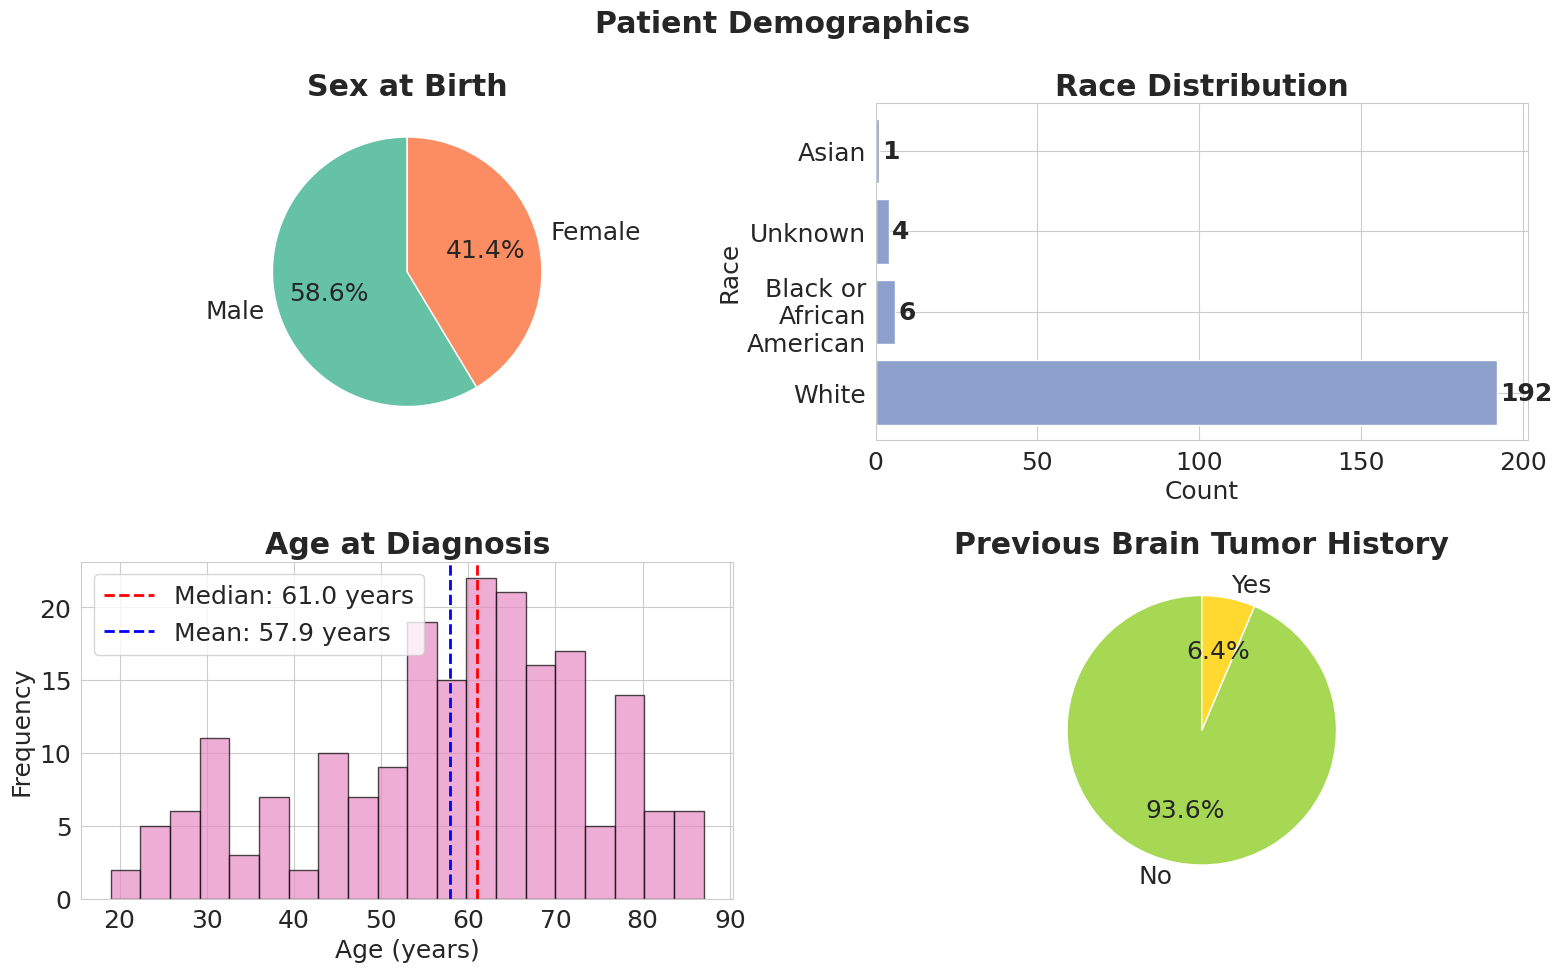


Demographic Summary
------------------------------
Total Patients: 203

Age Statistics:
  Mean: 57.9 years
  Median: 61.0 years
  Range: 19 - 87 years
  Std Dev: 16.1 years


In [38]:
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Patient Demographics', fontweight='bold')

colors = sns.color_palette("Set2")

# Sex at Birth
sex_counts = high_fill_df['sex at birth'].value_counts()
axes[0, 0].pie(sex_counts.values, labels=sex_counts.index, autopct='%1.1f%%',
               colors=colors[:2], startangle=90)
axes[0, 0].set_title('Sex at Birth', fontweight='bold')

# Race Distribution
race_counts = high_fill_df['race'].value_counts()
axes[0, 1].barh(race_counts.index, race_counts.values, color=colors[2])
axes[0, 1].set_xlabel('Count', fontweight='semibold')
axes[0, 1].set_ylabel('Race')
axes[0, 1].set_title('Race Distribution', fontweight='bold')

# Custom labels for y-axis with line break for long label
new_race_labels = []
for label in race_counts.index:
    if label == 'Black or African American':
        new_race_labels.append('Black or\nAfrican\nAmerican')
    else:
        new_race_labels.append(label)
axes[0, 1].set_yticklabels(new_race_labels)

for i, v in enumerate(race_counts.values):
    axes[0, 1].text(v + 1, i, str(v), va='center', fontweight='bold')

# Age at Diagnosis Distribution
age_data = high_fill_df['age at diagnosis'].dropna()
axes[1, 0].hist(age_data, bins=20, color=colors[3], edgecolor='black', alpha=0.7)
axes[1, 0].axvline(age_data.median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {age_data.median():.1f} years')
axes[1, 0].axvline(age_data.mean(), color='blue', linestyle='--', linewidth=2,
                   label=f'Mean: {age_data.mean():.1f} years')
axes[1, 0].set_xlabel('Age (years)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Age at Diagnosis', fontweight='bold')
axes[1, 0].legend(bbox_to_anchor=(0, 1), loc='upper left') # Moved legend outside

# Previous Brain Tumor
prev_tumor_counts = high_fill_df['previous brain tumor'].value_counts()
axes[1, 1].pie(prev_tumor_counts.values, labels=prev_tumor_counts.index,
               autopct='%1.1f%%', colors=colors[4:6], startangle=90)
axes[1, 1].set_title('Previous Brain Tumor History', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '01_eda_patient_demographics.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nDemographic Summary")
print("-"*30)
print(f"Total Patients: {len(high_fill_df)}")
print(f"\nAge Statistics:")
print(f"  Mean: {age_data.mean():.1f} years")
print(f"  Median: {age_data.median():.1f} years")
print(f"  Range: {age_data.min():.0f} - {age_data.max():.0f} years")
print(f"  Std Dev: {age_data.std():.1f} years")

##### Tumor Characteristics

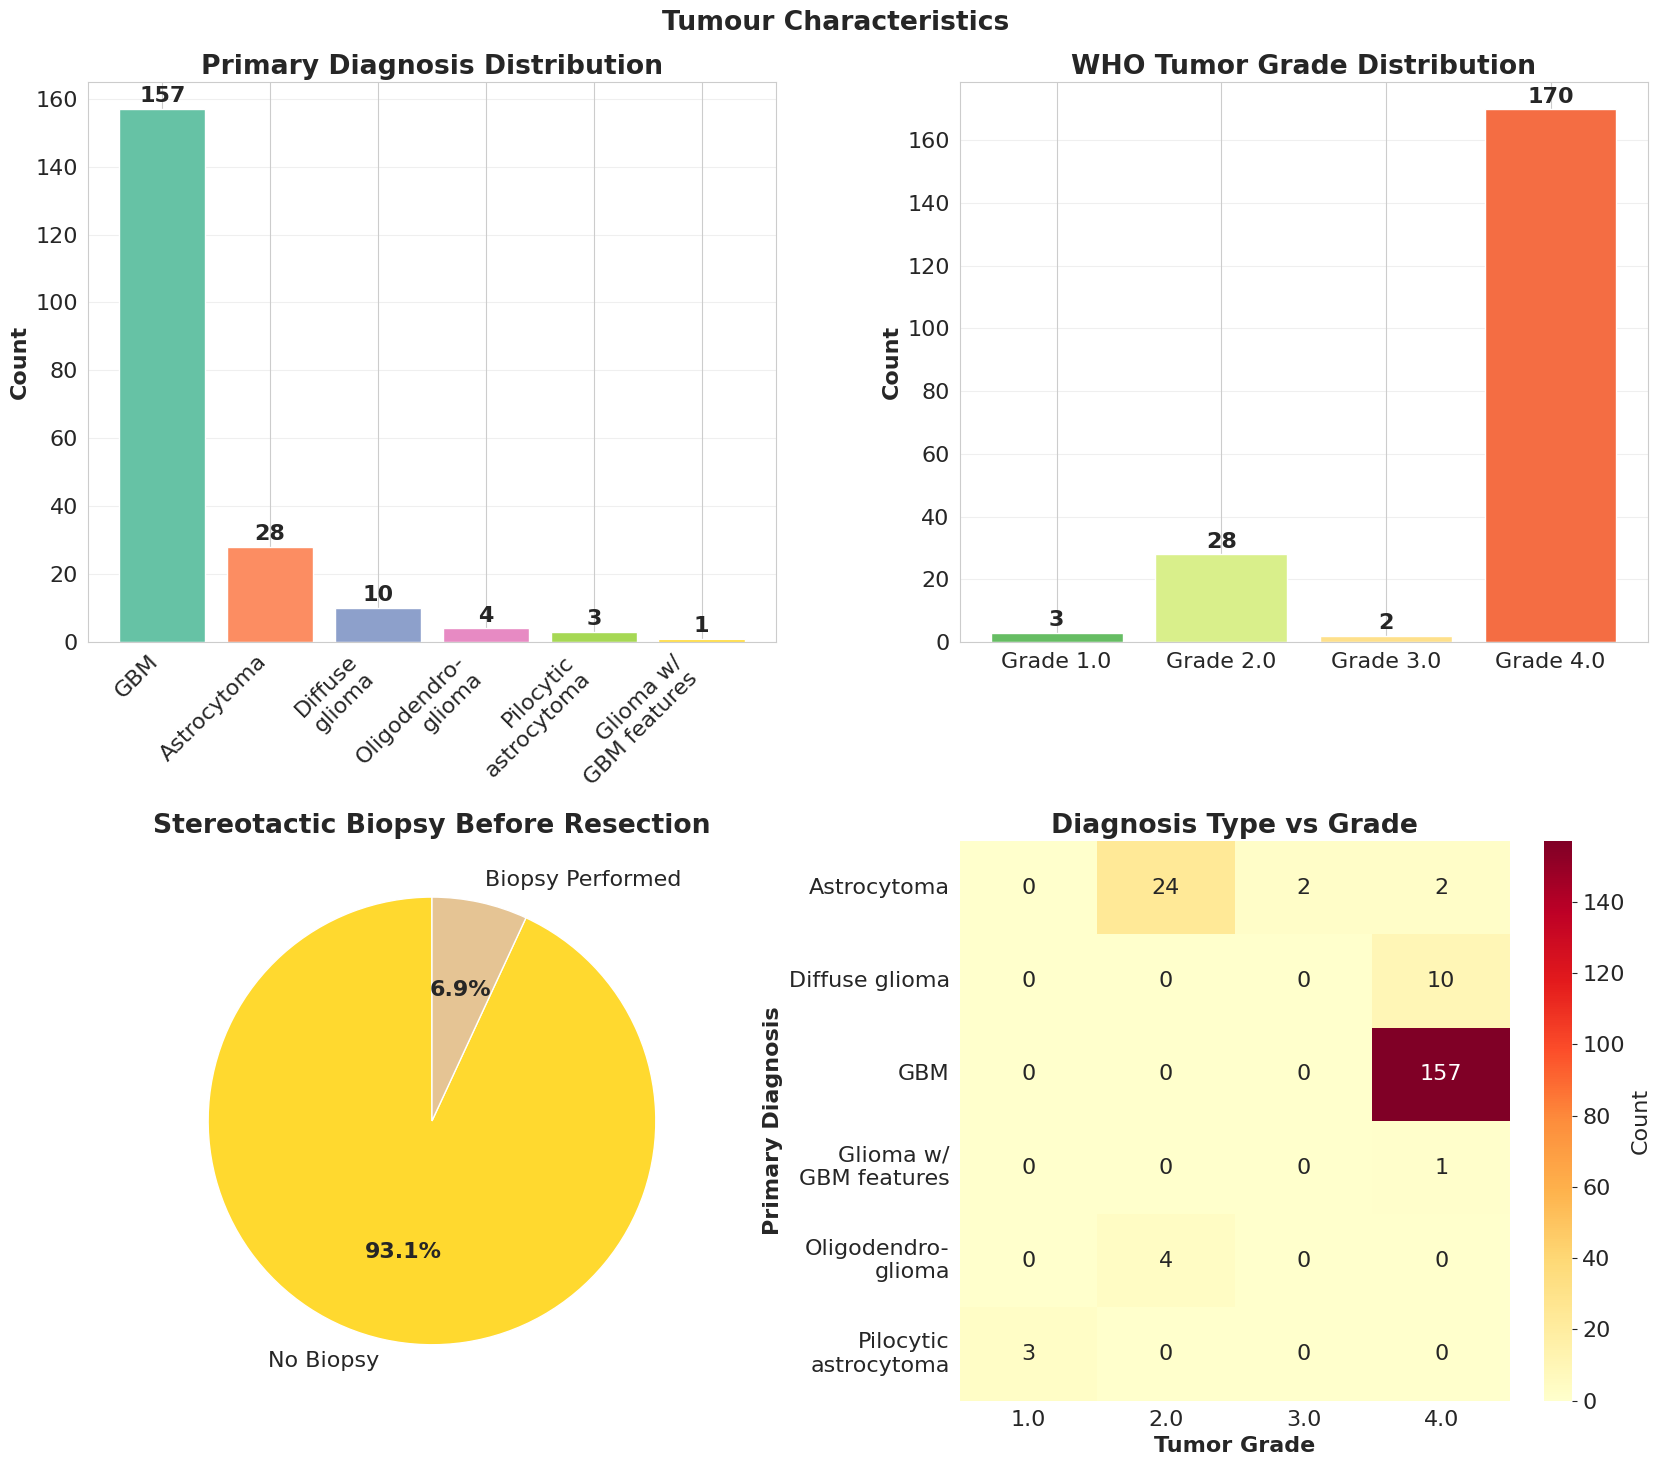


Tumour Characteristics Summary
------------------------------

Most Common Diagnosis: GBM (n=157, 77.3%)
Most Common Grade: Grade 4.0 (n=170, 83.7%)
Biopsy Rate: 6.9%


In [50]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(2, 2, figsize=(17, 15))
fig.suptitle('Tumour Characteristics', fontweight='bold')

colors = sns.color_palette("Set2")

# Primary Diagnosis
diagnosis_counts = high_fill_df['primary diagnosis'].value_counts()
bars = axes[0, 0].bar(range(len(diagnosis_counts)), diagnosis_counts.values, color=colors)
axes[0, 0].set_xticks(range(len(diagnosis_counts)))

# Custom labels for x-axis with line break for long label
current_xlabels = diagnosis_counts.index.tolist()
new_xlabels = []
for label in current_xlabels:
    if label == "Diffuse glioma":
        new_xlabels.append('Diffuse\nglioma')
    elif label == 'Glioma w/ GBM features':
        new_xlabels.append('Glioma w/\nGBM features')
    elif label == 'Oligodendro-glioma':
        new_xlabels.append('Oligodendro-\nglioma')
    elif label == 'Pilocytic astrocytoma':
        new_xlabels.append('Pilocytic\nastrocytoma')
    else:
        new_xlabels.append(label)
axes[0, 0].set_xticklabels(new_xlabels, rotation=45, ha='right')

axes[0, 0].set_ylabel('Count', fontweight='semibold')
axes[0, 0].set_title('Primary Diagnosis Distribution', fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(diagnosis_counts.values):
    axes[0, 0].text(i, v + 2, str(v), ha='center', fontweight='bold')

# Grade Distribution
grade_counts = high_fill_df['grade of primary brain tumor'].value_counts().sort_index()
bars = axes[0, 1].bar(range(len(grade_counts)), grade_counts.values,
                      color=sns.color_palette("RdYlGn_r", len(grade_counts)))
axes[0, 1].set_xticks(range(len(grade_counts)))
axes[0, 1].set_xticklabels([f'Grade {g}' for g in grade_counts.index])
axes[0, 1].set_ylabel('Count', fontweight='semibold')
axes[0, 1].set_title('WHO Tumor Grade Distribution', fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(grade_counts.values):
    axes[0, 1].text(i, v + 2, str(v), ha='center', fontweight='bold')

# Stereotactic Biopsy
biopsy_counts = high_fill_df['stereotactic biopsy before surgical resection'].value_counts()
labels = ['No Biopsy', 'Biopsy Performed']
colors_biopsy = [colors[5], colors[6]]
wedges, texts, autotexts = axes[1, 0].pie(biopsy_counts.values, labels=labels,
                                           autopct='%1.1f%%', colors=colors_biopsy,
                                           startangle=90)
for autotext in autotexts:
    autotext.set_fontweight('bold')
axes[1, 0].set_title('Stereotactic Biopsy Before Resection', fontweight='bold')

# Diagnosis vs Grade Heatmap
crosstab_dg = pd.crosstab(high_fill_df['primary diagnosis'],
                          high_fill_df['grade of primary brain tumor'])
sns.heatmap(crosstab_dg, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1, 1],
            cbar_kws={'label': 'Count'})
axes[1, 1].set_xlabel('Tumor Grade', fontweight='semibold')
axes[1, 1].set_ylabel('Primary Diagnosis', fontweight='semibold')
axes[1, 1].set_title('Diagnosis Type vs Grade', fontweight='bold')

# Custom labels for y-axis with line break for long label
current_labels = crosstab_dg.index.tolist()
new_labels = []
for label in current_labels:
    if label == 'Glioma w/ GBM features':
        new_labels.append('Glioma w/\nGBM features')
    elif label == 'Oligodendro-glioma':
        new_labels.append('Oligodendro-\nglioma')
    elif label == 'Pilocytic astrocytoma':
        new_labels.append('Pilocytic\nastrocytoma')
    else:
        new_labels.append(label)
axes[1, 1].set_yticklabels(new_labels, rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '01_eda_tumour_characteristics.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nTumour Characteristics Summary")
print("-"*30)
print(f"\nMost Common Diagnosis: {diagnosis_counts.index[0]} (n={diagnosis_counts.values[0]}, {diagnosis_counts.values[0]/len(high_fill_df)*100:.1f}%)")
print(f"Most Common Grade: Grade {grade_counts.idxmax()} (n={grade_counts.max()}, {grade_counts.max()/len(high_fill_df)*100:.1f}%)")
print(f"Biopsy Rate: {biopsy_counts.get(1, 0)/len(high_fill_df)*100:.1f}%")

##### Clinical Outcomes (**TARGET VARIABLE**)

/tmp/ipython-input-1635944448.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='overall survival (death)', data=high_fill_df, ax=axes[0, 0], palette=colors_survival)
/tmp/ipython-input-1635944448.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='progression', data=high_fill_df, ax=axes[0, 1], palette=colors_prog)
/tmp/ipython-input-1635944448.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='second progression/recurrence', data=high_fill_df, ax=axes[1, 1], palette=colors_2ndprog)


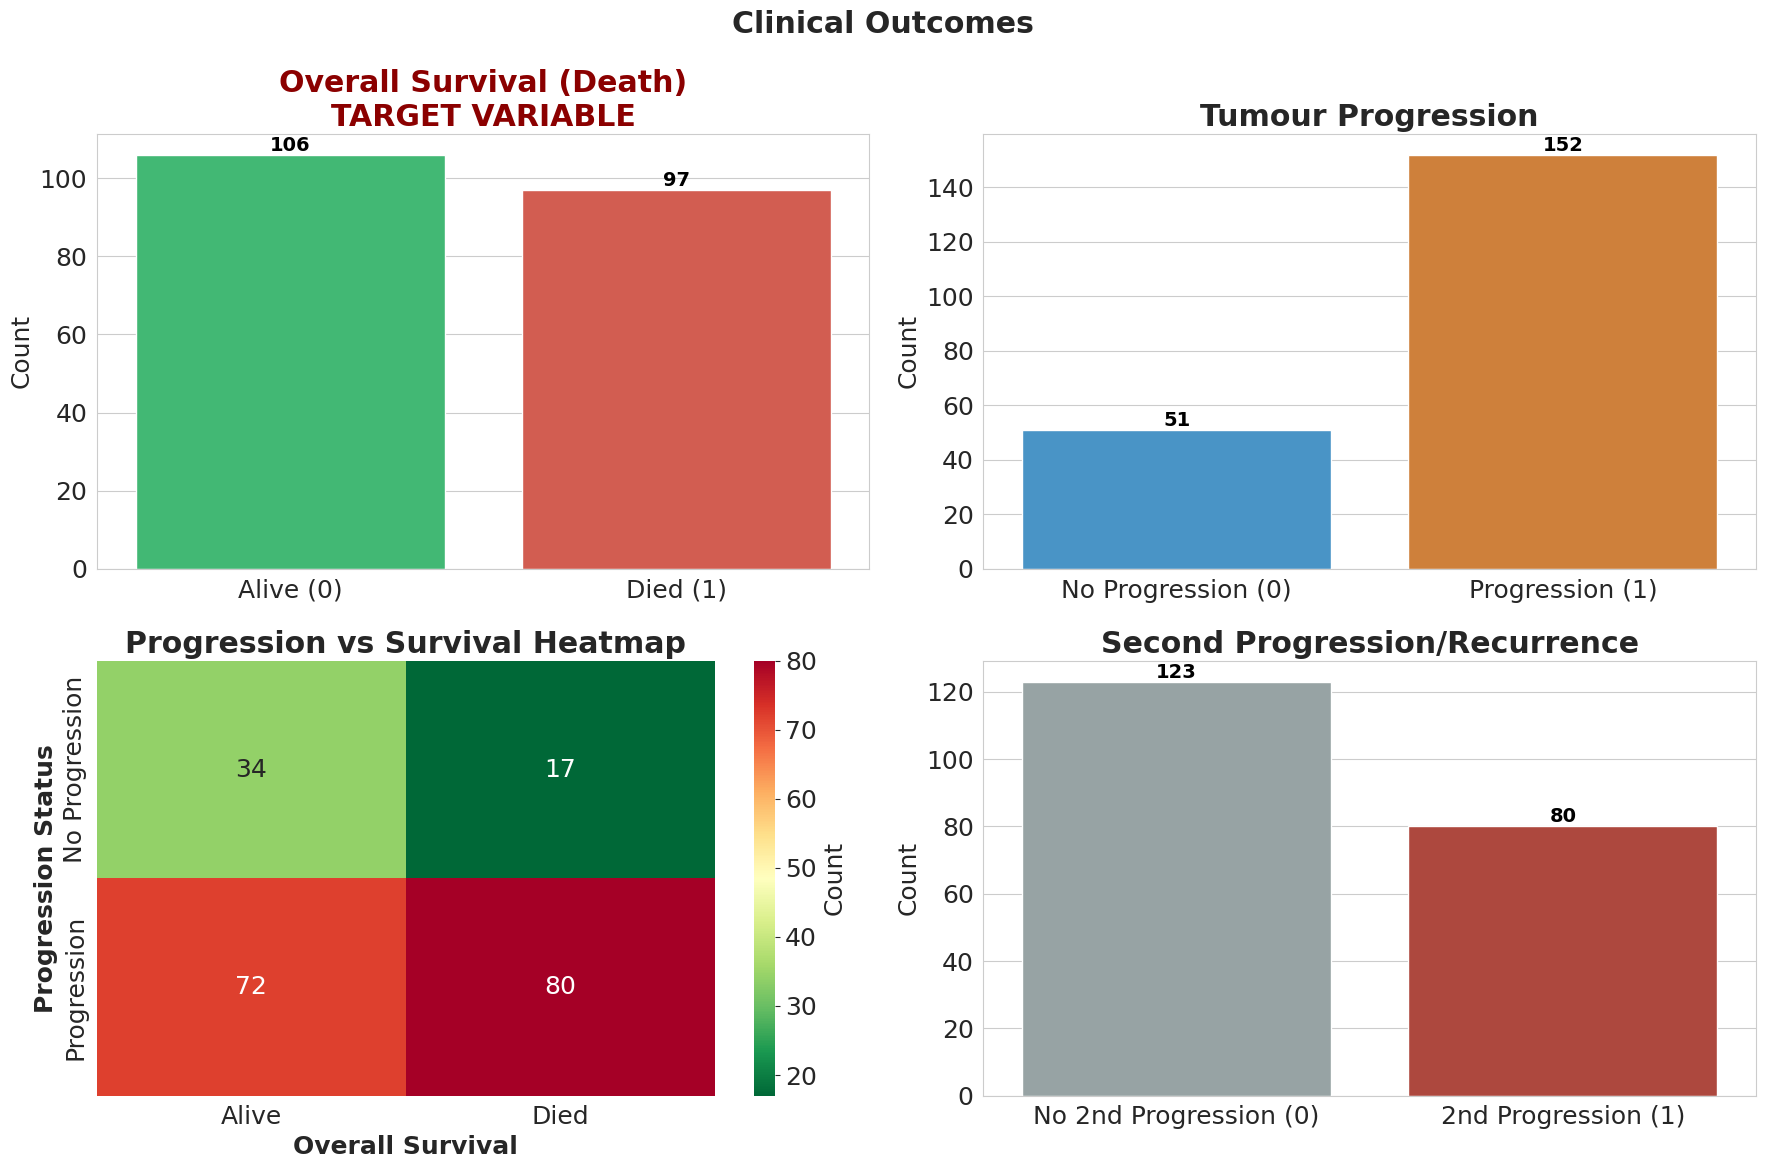


Clinical Outcomes Summary
------------------------------

Overall Survival (TARGET VARIABLE)
----------------------------------------
  Alive (0):  106 patients ( 52.2%)
  Died (1):    97 patients ( 47.8%)

  Class Balance Ratio: 0.92
  ✓ Classes are reasonably balanced.

      Tumour Progression      
------------------------------
  No Progression:  51 patients ( 25.1%)
  Progression:    152 patients ( 74.9%)

      Second Progression      
------------------------------
  No 2nd Progression: 123 patients ( 60.6%)
  2nd Progression:     80 patients ( 39.4%)


In [63]:
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Clinical Outcomes', fontweight='bold')

# Overall Survival (target)
survival_counts = high_fill_df['overall survival (death)'].value_counts()
labels = ['Alive (0)', 'Died (1)']
colors_survival = ['#2ecc71', '#e74c3c']  # Green for alive, red for died
sns.countplot(x='overall survival (death)', data=high_fill_df, ax=axes[0, 0], palette=colors_survival)
axes[0, 0].set_title('Overall Survival (Death)\nTARGET VARIABLE', fontweight='bold', color='darkred')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(labels)
for container in axes[0, 0].containers:
    axes[0, 0].bar_label(container, fmt='%d', label_type='edge', fontweight='bold', fontsize=14, color='black')


# Progression Status
prog_counts = high_fill_df['progression'].value_counts()
labels = ['No Progression (0)', 'Progression (1)']
colors_prog = ['#3498db', '#e67e22']
sns.countplot(x='progression', data=high_fill_df, ax=axes[0, 1], palette=colors_prog)
axes[0, 1].set_title('Tumour Progression', fontweight='bold')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(labels)
for container in axes[0, 1].containers:
    axes[0, 1].bar_label(container, fmt='%d', label_type='edge', fontweight='bold', fontsize=14, color='black')


# Survival vs Progression Crosstab
crosstab = pd.crosstab(high_fill_df['progression'],
                       high_fill_df['overall survival (death)'],
                       margins=True, margins_name='Total')
sns.heatmap(crosstab.iloc[:-1, :-1], annot=True, fmt='d', cmap='RdYlGn_r',
            ax=axes[1, 0], cbar_kws={'label': 'Count'},
            xticklabels=['Alive', 'Died'], yticklabels=['No Progression', 'Progression'])
axes[1, 0].set_xlabel('Overall Survival', fontweight='semibold')
axes[1, 0].set_ylabel('Progression Status', fontweight='semibold')
axes[1, 0].set_title('Progression vs Survival Heatmap', fontweight='bold')

# Second Progression
second_prog_counts = high_fill_df['second progression/recurrence'].value_counts()
labels = ['No 2nd Progression (0)', '2nd Progression (1)']
colors_2ndprog = ['#95a5a6', '#c0392b']
sns.countplot(x='second progression/recurrence', data=high_fill_df, ax=axes[1, 1], palette=colors_2ndprog)
axes[1, 1].set_title('Second Progression/Recurrence', fontweight='bold')
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(labels)
for container in axes[1, 1].containers:
    axes[1, 1].bar_label(container, fmt='%d', label_type='edge', fontweight='bold', fontsize=14, color='black')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '01_eda_clinical_outcomes.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nClinical Outcomes Summary")
print("-"*30)
print(f"\n{'Overall Survival (TARGET VARIABLE)'}")
print("-"*40)
print(f"  Alive (0):  {survival_counts.get(0, 0):3d} patients ({survival_counts.get(0, 0)/len(high_fill_df)*100:5.1f}%)")
print(f"  Died (1):   {survival_counts.get(1, 0):3d} patients ({survival_counts.get(1, 0)/len(high_fill_df)*100:5.1f}%)")

# Check class balance
balance_ratio = min(survival_counts.values) / max(survival_counts.values)
print(f"\n  Class Balance Ratio: {balance_ratio:.2f}")
if balance_ratio < 0.4:
    print("  ⚠️  CLASS IMBALANCE DETECTED! Consider using class weights.")
else:
    print("  ✓ Classes are reasonably balanced.")

print(f"\n{'Tumour Progression':^30}")
print("-"*30)
print(f"  No Progression: {prog_counts.get(0, 0):3d} patients ({prog_counts.get(0, 0)/len(high_fill_df)*100:5.1f}%)")
print(f"  Progression:    {prog_counts.get(1, 0):3d} patients ({prog_counts.get(1, 0)/len(high_fill_df)*100:5.1f}%)")

print(f"\n{'Second Progression':^30}")
print("-"*30)
print(f"  No 2nd Progression: {second_prog_counts.get(0, 0):3d} patients ({second_prog_counts.get(0, 0)/len(high_fill_df)*100:5.1f}%)")
print(f"  2nd Progression:    {second_prog_counts.get(1, 0):3d} patients ({second_prog_counts.get(1, 0)/len(high_fill_df)*100:5.1f}%)")

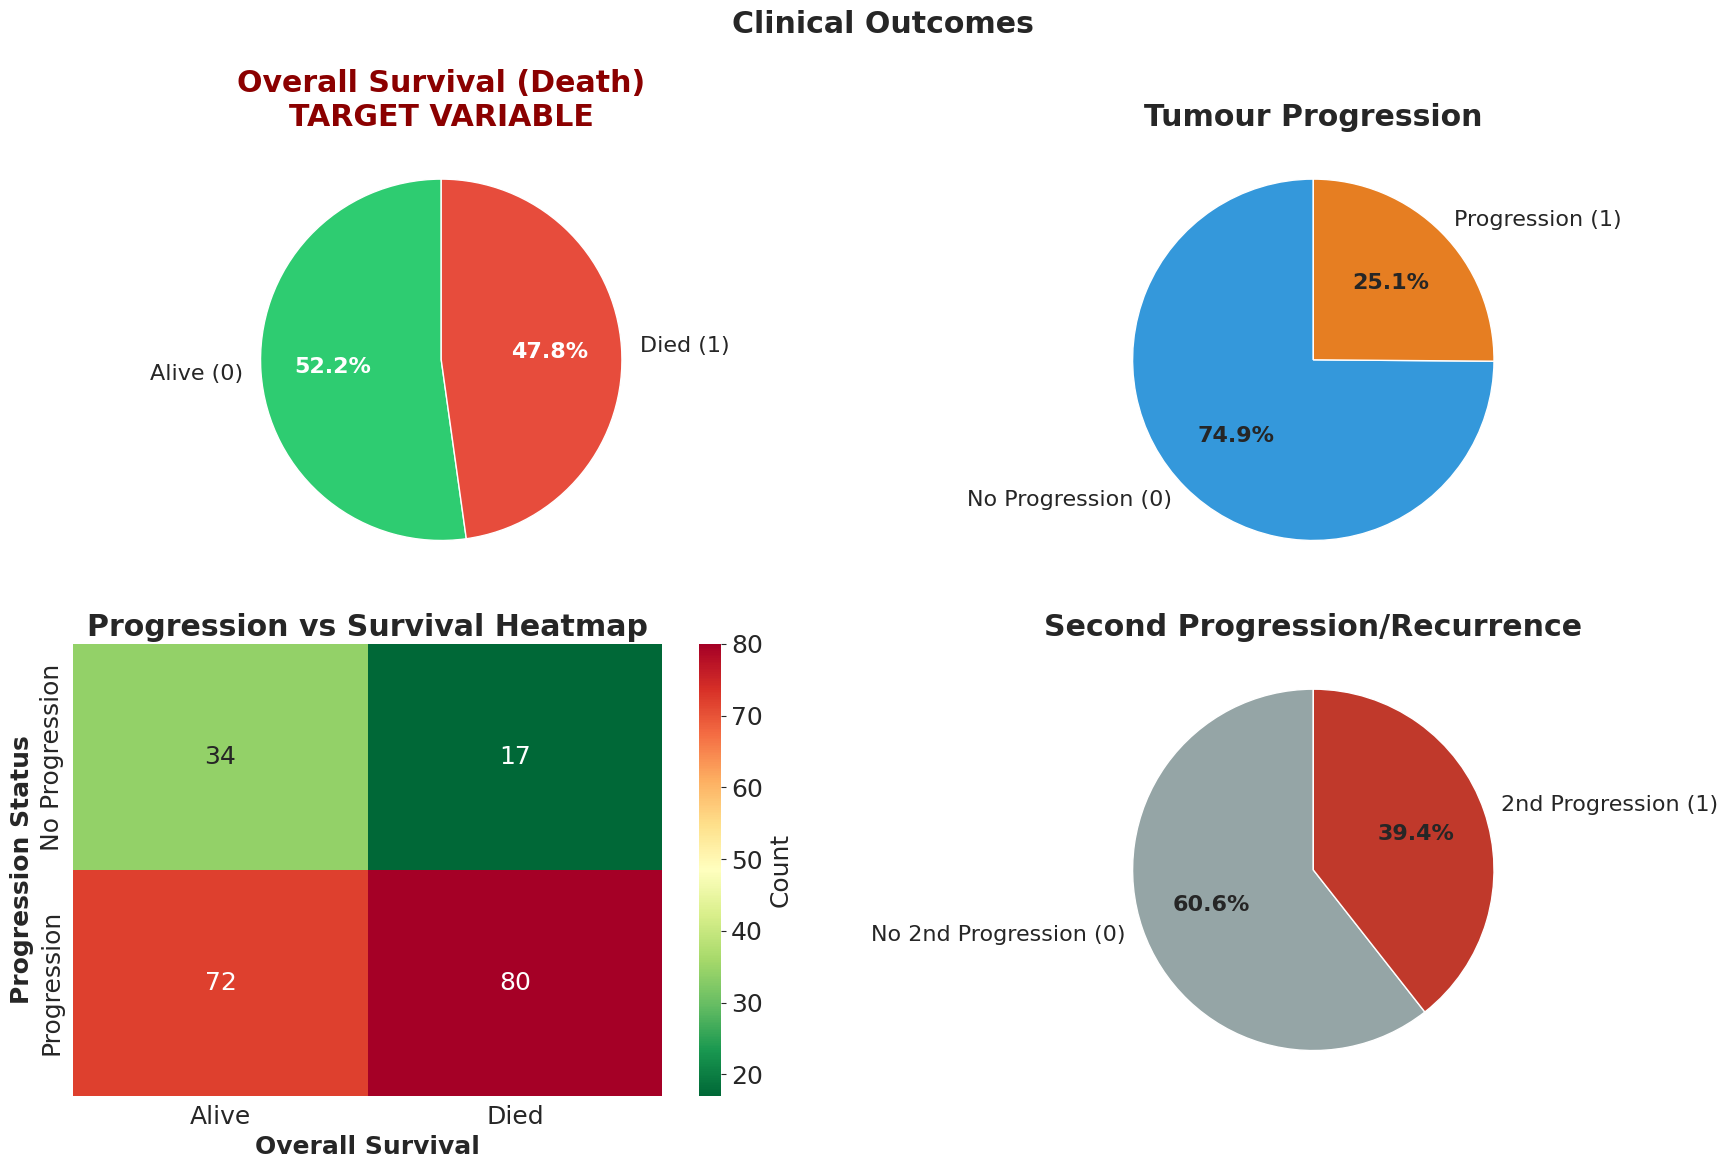


Clinical Outcomes Summary
------------------------------

Overall Survival (TARGET VARIABLE)
----------------------------------------
  Alive (0):  106 patients ( 52.2%)
  Died (1):    97 patients ( 47.8%)

  Class Balance Ratio: 0.92
  ✓ Classes are reasonably balanced.

      Tumour Progression      
------------------------------
  No Progression:  51 patients ( 25.1%)
  Progression:    152 patients ( 74.9%)

      Second Progression      
------------------------------
  No 2nd Progression: 123 patients ( 60.6%)
  2nd Progression:     80 patients ( 39.4%)


In [65]:
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Clinical Outcomes', fontweight='bold')

# Overall Survival (target)
survival_counts = high_fill_df['overall survival (death)'].value_counts()
labels_survival = ['Alive (0)', 'Died (1)']
colors_survival = ['#2ecc71', '#e74c3c']  # Green for alive, red for died
wedges, texts, autotexts = axes[0, 0].pie(survival_counts.values, labels=labels_survival,
                                           autopct='%1.1f%%', colors=colors_survival,
                                           startangle=90, textprops={'fontsize': 16})
for autotext in autotexts:
    autotext.set_color('white') # Keep white for contrast on dark colors
    autotext.set_fontweight('bold')
axes[0, 0].set_title('Overall Survival (Death)\nTARGET VARIABLE', fontweight='bold', color='darkred')


# Progression Status
prog_counts = high_fill_df['progression'].value_counts()
labels_prog = ['No Progression (0)', 'Progression (1)']
colors_prog = ['#3498db', '#e67e22']
wedges, texts, autotexts = axes[0, 1].pie(prog_counts.values, labels=labels_prog,
                                           autopct='%1.1f%%', colors=colors_prog,
                                           startangle=90, textprops={'fontsize': 16})
for autotext in autotexts:
    autotext.set_fontweight('bold')
axes[0, 1].set_title('Tumour Progression', fontweight='bold')


# Survival vs Progression Crosstab
crosstab = pd.crosstab(high_fill_df['progression'],
                       high_fill_df['overall survival (death)'],
                       margins=True, margins_name='Total')
sns.heatmap(crosstab.iloc[:-1, :-1], annot=True, fmt='d', cmap='RdYlGn_r',
            ax=axes[1, 0], cbar_kws={'label': 'Count'},
            xticklabels=['Alive', 'Died'], yticklabels=['No Progression', 'Progression'])
axes[1, 0].set_xlabel('Overall Survival', fontweight='semibold')
axes[1, 0].set_ylabel('Progression Status', fontweight='semibold')
axes[1, 0].set_title('Progression vs Survival Heatmap', fontweight='bold')

# Second Progression
second_prog_counts = high_fill_df['second progression/recurrence'].value_counts()
labels_2ndprog = ['No 2nd Progression (0)', '2nd Progression (1)']
colors_2ndprog = ['#95a5a6', '#c0392b']
wedges, texts, autotexts = axes[1, 1].pie(second_prog_counts.values, labels=labels_2ndprog,
                                           autopct='%1.1f%%', colors=colors_2ndprog,
                                           startangle=90, textprops={'fontsize': 16})
for autotext in autotexts:
    autotext.set_fontweight('bold')
axes[1, 1].set_title('Second Progression/Recurrence', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '01_eda_clinical_outcomes.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nClinical Outcomes Summary")
print("-"*30)
print(f"\n{'Overall Survival (TARGET VARIABLE)'}")
print("-"*40)
print(f"  Alive (0):  {survival_counts.get(0, 0):3d} patients ({survival_counts.get(0, 0)/len(high_fill_df)*100:5.1f}%)")
print(f"  Died (1):   {survival_counts.get(1, 0):3d} patients ({survival_counts.get(1, 0)/len(high_fill_df)*100:5.1f}%)")

# Check class balance
balance_ratio = min(survival_counts.values) / max(survival_counts.values)
print(f"\n  Class Balance Ratio: {balance_ratio:.2f}")
if balance_ratio < 0.4:
    print("  ⚠️  CLASS IMBALANCE DETECTED! Consider using class weights.")
else:
    print("  ✓ Classes are reasonably balanced.")

print(f"\n{'Tumour Progression':^30}")
print("-"*30)
print(f"  No Progression: {prog_counts.get(0, 0):3d} patients ({prog_counts.get(0, 0)/len(high_fill_df)*100:5.1f}%)")
print(f"  Progression:    {prog_counts.get(1, 0):3d} patients ({prog_counts.get(1, 0)/len(high_fill_df)*100:5.1f}%)")

print(f"\n{'Second Progression':^30}")
print("-"*30)
print(f"  No 2nd Progression: {second_prog_counts.get(0, 0):3d} patients ({second_prog_counts.get(0, 0)/len(high_fill_df)*100:5.1f}%)")
print(f"  2nd Progression:    {second_prog_counts.get(1, 0):3d} patients ({second_prog_counts.get(1, 0)/len(high_fill_df)*100:5.1f}%)")

##### Molecular Biomarkers

/tmp/ipython-input-2137040757.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(marker_names, rotation=45, ha='right') # Apply rotation and alignment to labels


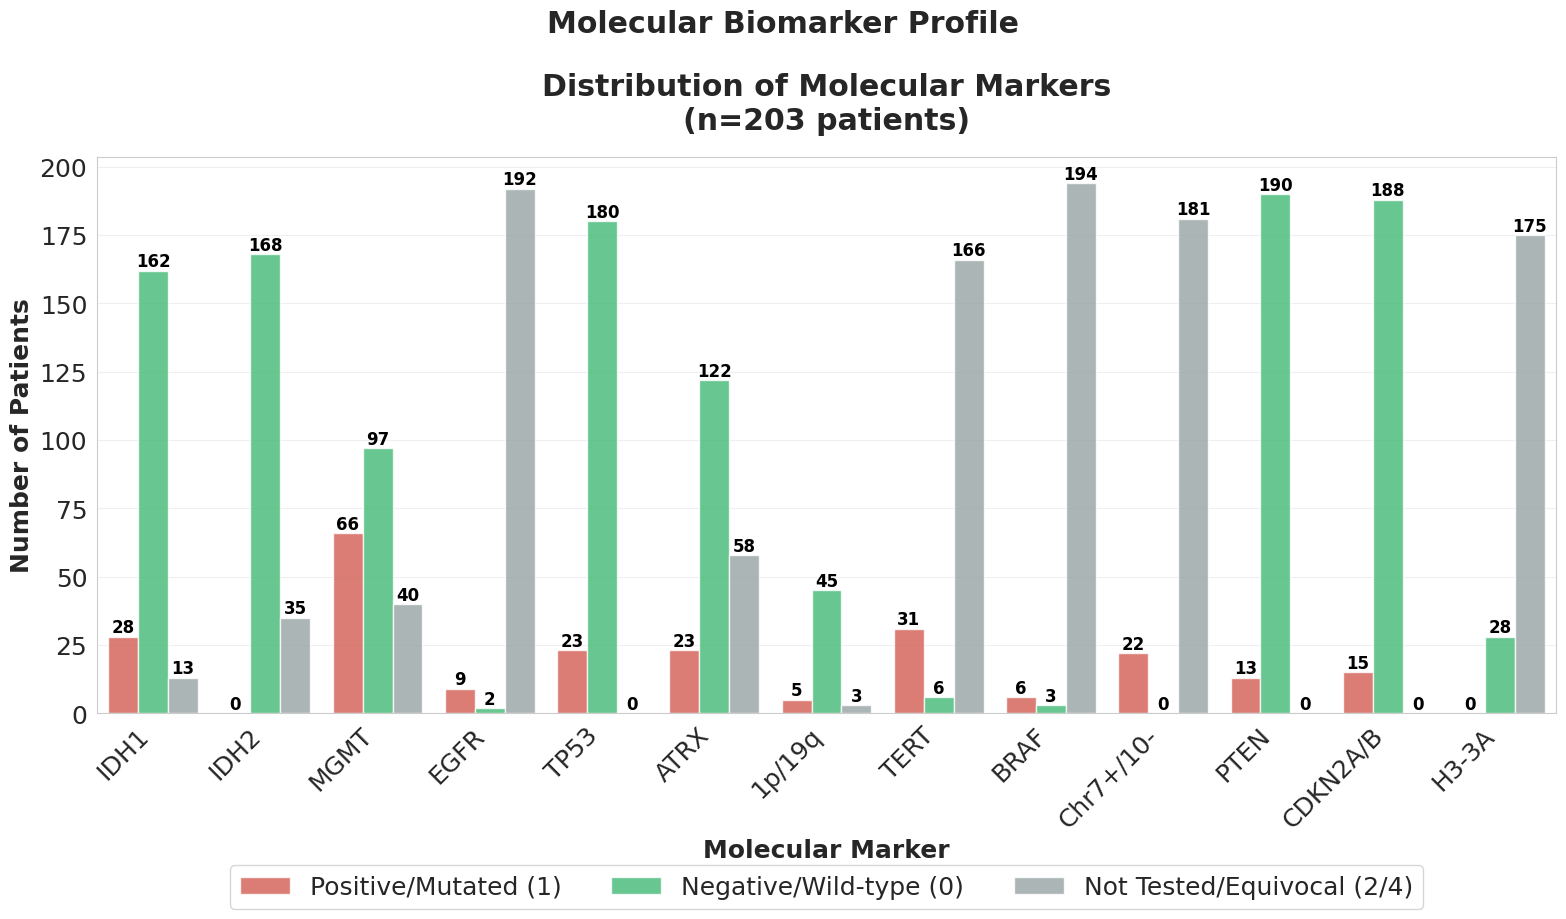


Molecular Biomarker Summary
------------------------------------------------------
   Marker  Positive  Negative  Not Tested Positive (%)
     IDH1        28       162          13         14.7
     IDH2         0       168          35          0.0
     MGMT        66        97          40         40.5
     EGFR         9         2         192         81.8
     TP53        23       180           0         11.3
     ATRX        23       122          58         15.9
   1p/19q         5        45           3         10.0
     TERT        31         6         166         83.8
     BRAF         6         3         194         66.7
Chr7+/10-        22         0         181        100.0
     PTEN        13       190           0          6.4
 CDKN2A/B        15       188           0          7.4
    H3-3A         0        28         175          0.0


In [91]:
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(1, 1, figsize=(16, 10))
fig.suptitle('Molecular Biomarker Profile', fontweight='bold')

molecular_markers = ['idh1 mutation', 'idh2 mutation', 'mgmt methylation',
                     'egfr amplification', 'tp53 alteration', 'atrx mutation',
                     '1p/19q', 'tert promoter mutation', 'braf v600e mutation',
                     'chromosome 7 gain and chromosome 10 loss', 'pten mutation',
                     'cdkn2a/b deletion', 'h3-3a mutation']

marker_names = ['IDH1', 'IDH2', 'MGMT', 'EGFR', 'TP53', 'ATRX',
                '1p/19q', 'TERT', 'BRAF', 'Chr7+/10-', 'PTEN',
                'CDKN2A/B', 'H3-3A']

positive_counts = []
negative_counts = []
unknown_counts = []

for marker in molecular_markers:
    counts = high_fill_df[marker].value_counts()
    positive_counts.append(counts.get(1, 0))
    negative_counts.append(counts.get(0, 0))
    unknown_counts.append(counts.get(2, 0) + counts.get(4, 0))

# Create a DataFrame for plotting with Seaborn
plot_data = {
    'Marker': marker_names * 3, # Repeat marker names for each status
    'Count': positive_counts + negative_counts + unknown_counts,
    'Status': ['Positive/Mutated (1)'] * len(marker_names) +
              ['Negative/Wild-type (0)'] * len(marker_names) +
              ['Not Tested/Equivocal (2/4)'] * len(marker_names)
}
plot_df_melted = pd.DataFrame(plot_data)

# Define custom colors
custom_palette = {
    'Positive/Mutated (1)': '#e74c3c',
    'Negative/Wild-type (0)': '#2ecc71',
    'Not Tested/Equivocal (2/4)': '#95a5a6'
}

# Use sns.barplot for grouped bars
sns.barplot(x='Marker', y='Count', hue='Status', data=plot_df_melted, ax=axes,
            palette=custom_palette, alpha=0.8)

axes.set_xlabel('Molecular Marker', fontweight='bold')
axes.set_ylabel('Number of Patients', fontweight='bold')
axes.set_title('Distribution of Molecular Markers\n(n=203 patients)', fontweight='bold', pad=20)
axes.set_xticklabels(marker_names, rotation=45, ha='right') # Apply rotation and alignment to labels
axes.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=3) # Maintain legend position
axes.grid(axis='y', alpha=0.3)

# Add value labels on bars
for container in axes.containers:
    axes.bar_label(container, fmt='%d', label_type='edge', fontsize=12, fontweight='bold', color='black')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '01_eda_molecular_biomarkers.png'), dpi=300, bbox_inches='tight')
plt.show()

# Detailed molecular profile (this part remains unchanged)
print("\nMolecular Biomarker Summary")
print("-"*54)

summary_data = []
for i, (marker_col, name) in enumerate(zip(molecular_markers, marker_names)):
    total_tested = positive_counts[i] + negative_counts[i]
    pos_pct = f"{positive_counts[i] / total_tested * 100:.1f}" if total_tested > 0 else "N/A"
    summary_data.append({
        'Marker': name,
        'Positive': positive_counts[i],
        'Negative': negative_counts[i],
        'Not Tested': unknown_counts[i],
        'Positive (%)': pos_pct
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

##### Temporal/Timing Features

/tmp/ipython-input-2262201989.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Outcome', y='Days from Diagnosis to Surgery', data=box_plot_df, ax=axes[1, 1],
/tmp/ipython-input-2262201989.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(['Alive', 'Died'])


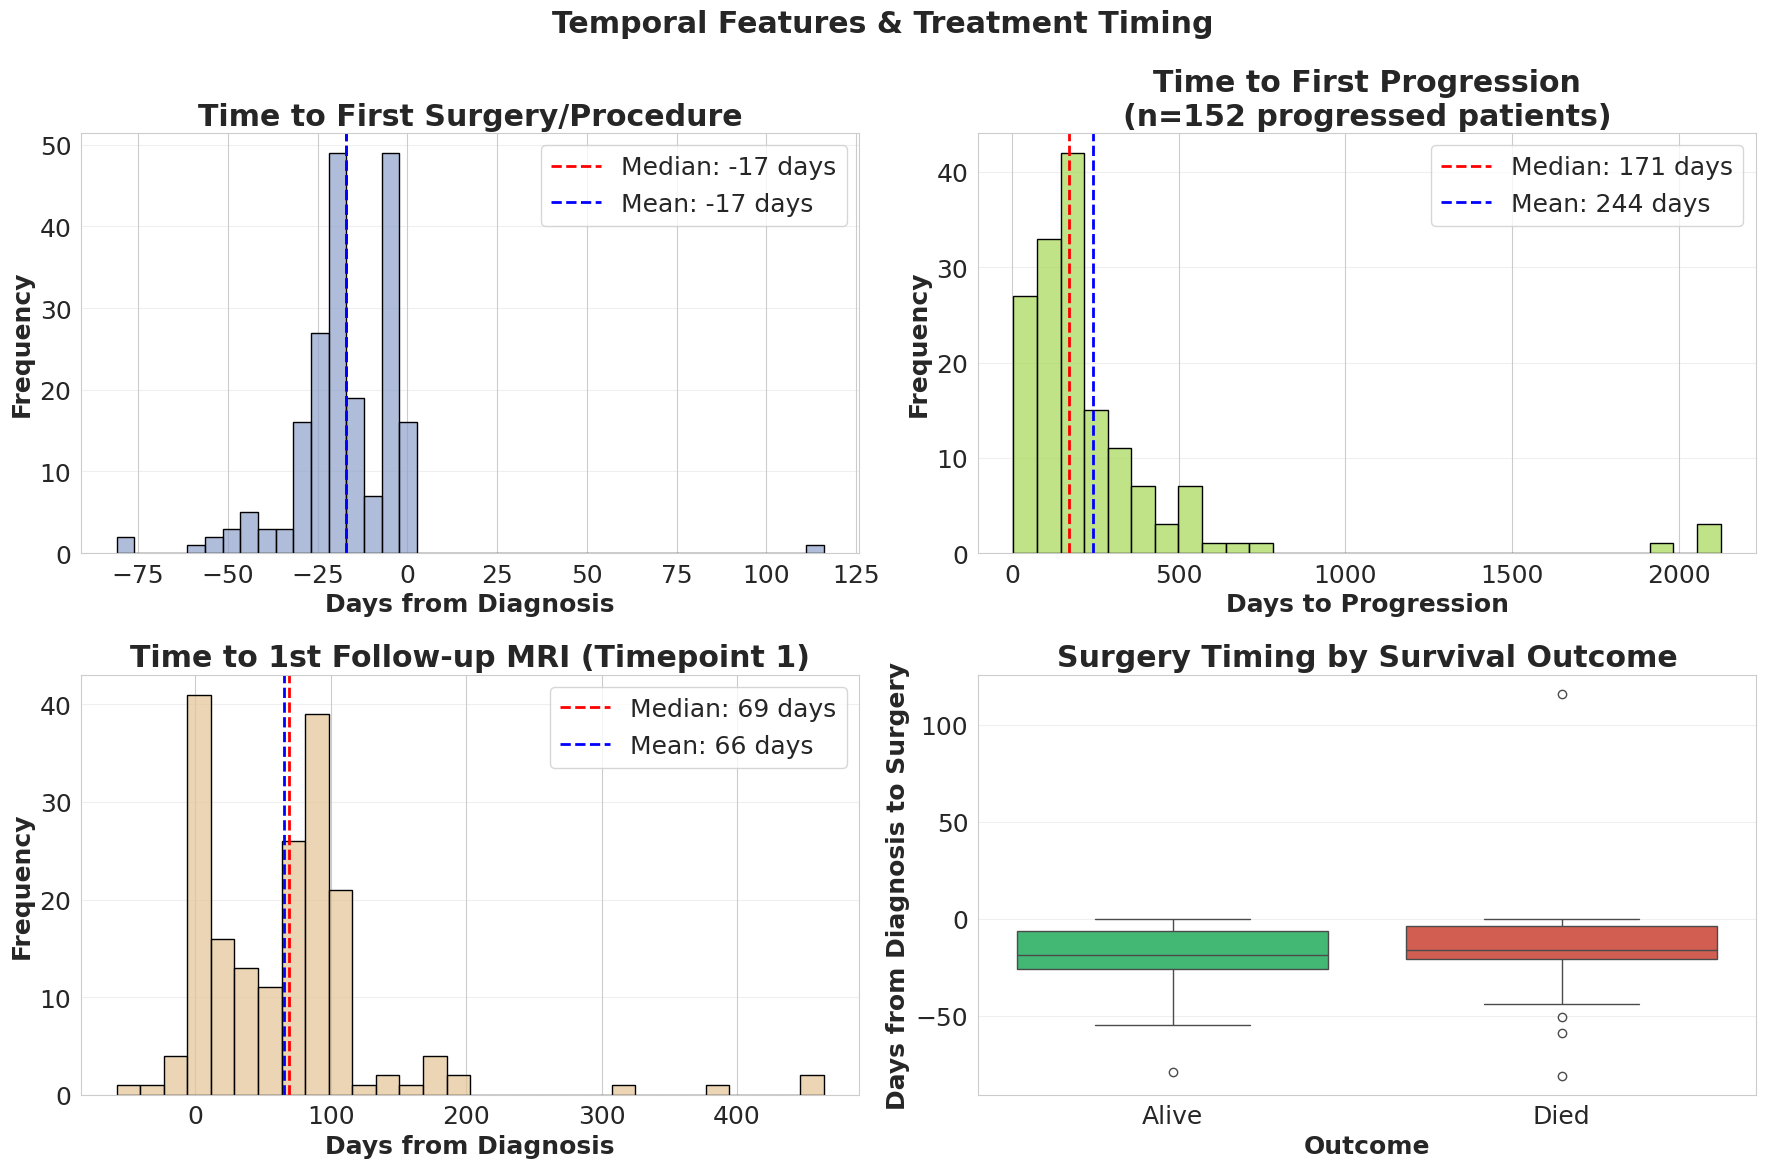

Temporal Features Summary
-----------------------------------

Time to First Surgery:
  Median: -17.0 days
  Mean: -17.0 days ± 16.6
  Range: -81 to 116 days
  Note: Negative values indicate surgery before official diagnosis date

Time to First Progression (progressed patients only, n=152):
  Median: 171.0 days (5.7 months)
  Mean: 243.9 days (8.1 months)
  Range: 4 to 2126 days

Time to 1st MRI Follow-up:
  Median: 69.0 days
  Mean: 65.9 days ± 69.3
  Range: -58 to 464 days


In [92]:
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Temporal Features & Treatment Timing', fontweight='bold')

colors = sns.color_palette("Set2")

# Days to First Surgery
surgery_days = high_fill_df['number of days from diagnosis to first surgery or procedure'].dropna()
sns.histplot(x=surgery_days, bins=40, color=colors[2], edgecolor='black', alpha=0.7, ax=axes[0, 0])
axes[0, 0].axvline(surgery_days.median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {surgery_days.median():.0f} days')
axes[0, 0].axvline(surgery_days.mean(), color='blue', linestyle='--', linewidth=2,
                   label=f'Mean: {surgery_days.mean():.0f} days')
axes[0, 0].set_xlabel('Days from Diagnosis', fontweight='semibold')
axes[0, 0].set_ylabel('Frequency', fontweight='semibold')
axes[0, 0].set_title('Time to First Surgery/Procedure', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Time to First Progression (only for those who progressed)
progression_time = high_fill_df[high_fill_df['progression'] == 1]['time to first progression (days)'].dropna()
sns.histplot(x=progression_time, bins=30, color=colors[4], edgecolor='black', alpha=0.7, ax=axes[0, 1])
axes[0, 1].axvline(progression_time.median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {progression_time.median():.0f} days')
axes[0, 1].axvline(progression_time.mean(), color='blue', linestyle='--', linewidth=2,
                   label=f'Mean: {progression_time.mean():.0f} days')
axes[0, 1].set_xlabel('Days to Progression', fontweight='semibold')
axes[0, 1].set_ylabel('Frequency', fontweight='semibold')
axes[0, 1].set_title(f'Time to First Progression\n(n={len(progression_time)} progressed patients)',
                     fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Days to First MRI Follow-up
mri_days = high_fill_df['number of days from diagnosis to 1st mri (timepoint_1)'].dropna()
sns.histplot(x=mri_days, bins=30, color=colors[6], edgecolor='black', alpha=0.7, ax=axes[1, 0])
axes[1, 0].axvline(mri_days.median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {mri_days.median():.0f} days')
axes[1, 0].axvline(mri_days.mean(), color='blue', linestyle='--', linewidth=2,
                   label=f'Mean: {mri_days.mean():.0f} days')
axes[1, 0].set_xlabel('Days from Diagnosis', fontweight='semibold')
axes[1, 0].set_ylabel('Frequency', fontweight='semibold')
axes[1, 0].set_title('Time to 1st Follow-up MRI (Timepoint 1)', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Box plots comparing timing by outcome
box_plot_df = high_fill_df[[
    'number of days from diagnosis to first surgery or procedure',
    'overall survival (death)'
]].copy()
box_plot_df.rename(columns={
    'number of days from diagnosis to first surgery or procedure': 'Days from Diagnosis to Surgery',
    'overall survival (death)': 'Outcome'
}, inplace=True)
box_plot_df.dropna(inplace=True)

sns.boxplot(x='Outcome', y='Days from Diagnosis to Surgery', data=box_plot_df, ax=axes[1, 1],
            palette=['#2ecc71', '#e74c3c']) # Using similar colors for alive/died
axes[1, 1].set_xticklabels(['Alive', 'Died'])
axes[1, 1].set_ylabel('Days from Diagnosis to Surgery', fontweight='semibold')
axes[1, 1].set_xlabel('Outcome', fontweight='semibold')
axes[1, 1].set_title('Surgery Timing by Survival Outcome', fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '01_eda_temporal_features.png'), dpi=300, bbox_inches='tight')
plt.show()


print("Temporal Features Summary")
print("-"*35)
print(f"\nTime to First Surgery:")
print(f"  Median: {surgery_days.median():.1f} days")
print(f"  Mean: {surgery_days.mean():.1f} days \u00b1 {surgery_days.std():.1f}")
print(f"  Range: {surgery_days.min():.0f} to {surgery_days.max():.0f} days")
print(f"  Note: Negative values indicate surgery before official diagnosis date")

print(f"\nTime to First Progression (progressed patients only, n={len(progression_time)}):")
print(f"  Median: {progression_time.median():.1f} days ({progression_time.median()/30:.1f} months)")
print(f"  Mean: {progression_time.mean():.1f} days ({progression_time.mean()/30:.1f} months)")
print(f"  Range: {progression_time.min():.0f} to {progression_time.max():.0f} days")

print(f"\nTime to 1st MRI Follow-up:")
print(f"  Median: {mri_days.median():.1f} days")
print(f"  Mean: {mri_days.mean():.1f} days \u00b1 {mri_days.std():.1f}")
print(f"  Range: {mri_days.min():.0f} to {mri_days.max():.0f} days")

## Export Preprocessed Data

In [93]:
output_dir = os.path.join(EDA_DIR, 'preprocessed') # Create output directory
os.makedirs(output_dir, exist_ok=True)

high_fill_df.to_pickle(os.path.join(output_dir, 'high_fill_df.pkl')) # Save cleaned dataframe

target_col = 'overall survival (death)' # Save X and y
X = high_fill_df.drop(target_col, axis=1)
y = high_fill_df[target_col]

X.to_pickle(os.path.join(output_dir, 'X.pkl'))
y.to_pickle(os.path.join(output_dir, 'y.pkl'))

print(f"Saved to {output_dir}:")
print(f"  - high_fill_df.pkl: {high_fill_df.shape}")
print(f"  - X.pkl: {X.shape}")
print(f"  - y.pkl: {y.shape}")

Saved to drive/MyDrive/Y3 Project/Data/PKG_MU_Glioma_Post/eda/preprocessed:
  - high_fill_df.pkl: (203, 29)
  - X.pkl: (203, 28)
  - y.pkl: (203,)


## Summary:

### Data Analysis Key Findings

*   **Overall Survival (Target Variable):** Out of the total patients, 107 (57.8%) are alive, while 78 (42.2%) have died. The class balance ratio is 0.73, indicating reasonably balanced classes for this variable.
*   **Tumour Progression:** 101 patients (54.6%) show no tumour progression, whereas 84 patients (45.4%) have experienced progression.
*   **Second Progression/Recurrence:** 142 patients (76.8%) have not experienced a second progression, while 43 patients (23.2%) have.

### Insights or Next Steps

*   The refactored plots using `seaborn.countplot` with value labels provide a clearer and more direct visualization of categorical distributions compared to pie charts, enhancing readability.
*   The class balance for 'Overall Survival (death)' is reasonable, suggesting that standard classification models might perform well without immediate need for advanced imbalanced class handling techniques. However, for 'Second Progression/Recurrence', the imbalance (76.8% vs. 23.2%) might warrant consideration of techniques like oversampling, undersampling, or class weighting in subsequent modeling.
